# Baseline Results for Multiclass Classification (pain area in body)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.utils import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras import Model

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, load_fusioned_dataset
from src.lib.DeepStack.deepstack.base import KerasMember
from src.lib.DeepStack.deepstack.ensemble import DirichletEnsemble

In [2]:
epochs, batch_size = 50, 32
kf = KFold(n_splits=3, shuffle=True, random_state=42)

results = []

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    )

In [3]:
class Baseline():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(n_length, n_features))
        lstm = LSTM(50)(input)
        dense = Dense(50)(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def summary(self):
        self.model.summary()

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(380, 350, 35) (380, 4)
(235, 350, 35) (235, 4)


In [5]:
classes = get_class_names('skeleton', nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Lower Body       245
Back Region       73
Upper Body        57
Head and Neck      5
dtype: int64

In [6]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.3013698630136987, 1: 19.0, 2: 0.3877551020408163, 3: 1.6666666666666667}

In [7]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 35)]         0         
                                                                 
 lstm (LSTM)                 (None, 50)                17200     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 19,954
Trainable params: 19,954
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 4s - loss: 1.9159 - accuracy: 0.3676 - auc_1: 0.6869 - precision_1: 0.2812 - recall_1: 0.1423 - f1_score: 0.1936 - val_loss: 1.2452 - val_accuracy: 0.3622 - val_auc_1: 0.7020 - val_precision_1: 0.3333 - val_recall_1: 0.1575 - val_f1_score: 0.1678 - 4s/epoch - 439ms/step
Epoch 2/50
8/8 - 1s - loss: 1.8423 - accuracy: 0.3636 - auc_1: 0.6994 - precision_1: 0.3214 - recall_1: 0.1423 - f1_score: 0.1905 - val_loss: 1.2325 - val_accuracy: 0.3465 - val_auc_1: 0.7111 - val_precision_1: 0.3333 - val_recall_1: 0.1417 - val_f1_score: 0.1667 - 886ms/epoch - 111ms/step
Epoch 3/50
8/8 - 1s - loss: 1.7656 - accuracy: 0.3676 - auc_1: 0.7044 - precision_1: 0.3696 - recall_1: 0.1344 - f1_score: 0.1921 - val_loss: 1.2337 - val_accuracy: 0.3780 - val_auc_1: 0.7110 - val_precision_1: 0.3469 - val_recall_1: 0.1339 - val_f1_score: 0.1817 - 722ms/epoch - 90ms/step
Epoch 4/50
8/8 - 1s - loss: 1.7328 - accuracy: 0.3794 - auc_1: 0.7117 - precision_1: 0.4177 - recall_1: 0.1304 - f1_score: 0.1972 -

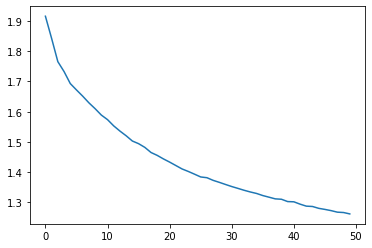

Epoch 1/50
8/8 - 3s - loss: 1.6064 - accuracy: 0.0277 - auc_2: 0.1793 - precision_2: 0.0333 - recall_2: 0.0040 - f1_score: 0.0355 - val_loss: 1.9812 - val_accuracy: 0.0472 - val_auc_2: 0.2305 - val_precision_2: 0.1250 - val_recall_2: 0.0079 - val_f1_score: 0.0666 - 3s/epoch - 346ms/step
Epoch 2/50
8/8 - 1s - loss: 1.5340 - accuracy: 0.0316 - auc_2: 0.1855 - precision_2: 0.0667 - recall_2: 0.0040 - f1_score: 0.0393 - val_loss: 1.8814 - val_accuracy: 0.0630 - val_auc_2: 0.2343 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.0939 - 713ms/epoch - 89ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4872 - accuracy: 0.0553 - auc_2: 0.1952 - precision_2: 0.0909 - recall_2: 0.0040 - f1_score: 0.0796 - val_loss: 1.8239 - val_accuracy: 0.0787 - val_auc_2: 0.2376 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.1112 - 671ms/epoch - 84ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4619 - accuracy: 0.0711 - auc_2: 0.2071 - precision_2: 0.1250 - recall_2: 0.0040 - f1_

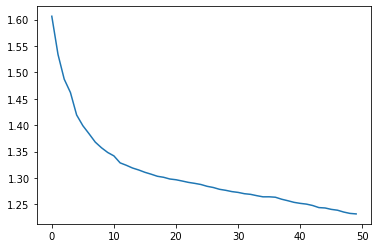

Epoch 1/50
8/8 - 3s - loss: 1.2927 - accuracy: 0.1732 - auc_3: 0.5172 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.1279 - val_loss: 1.3839 - val_accuracy: 0.1667 - val_auc_3: 0.5538 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1477 - 3s/epoch - 369ms/step
Epoch 2/50
8/8 - 1s - loss: 1.2621 - accuracy: 0.1890 - auc_3: 0.5616 - precision_3: 1.0000 - recall_3: 0.0039 - f1_score: 0.1382 - val_loss: 1.3657 - val_accuracy: 0.2063 - val_auc_3: 0.5861 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.1943 - 647ms/epoch - 81ms/step
Epoch 3/50
8/8 - 1s - loss: 1.2443 - accuracy: 0.2008 - auc_3: 0.5835 - precision_3: 1.0000 - recall_3: 0.0079 - f1_score: 0.1447 - val_loss: 1.3535 - val_accuracy: 0.2143 - val_auc_3: 0.6036 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.2004 - 642ms/epoch - 80ms/step
Epoch 4/50
8/8 - 1s - loss: 1.2327 - accuracy: 0.2244 - auc_3: 0.5914 - precision_3: 1.0000 - recall

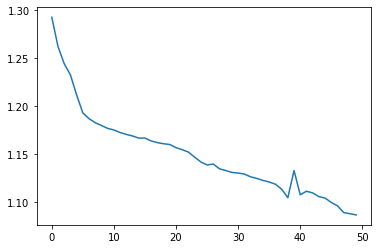

In [8]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    baseline_body_model = Baseline(n_features, n_length, n_outputs)
    history = baseline_body_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on holdout set

In [9]:
y_pred = baseline_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = baseline_body_model.evaluate(X_test, y_test)
results.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 40.00% 
Balanced Accuracy: 28.55% 
ROC/AUC: 0.70 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.28


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [10]:
X_train, X_test, y_train, y_test = load_dataset('AUs', nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(366, 350, 25) (366, 4)
(231, 350, 25) (231, 4)


In [11]:
classes = get_class_names('AUs', nopain=False)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

Lower Body       236
Back Region       69
Upper Body        57
Head and Neck      4
dtype: int64

In [12]:
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.326086956521739, 1: 22.875, 2: 0.3877118644067797, 3: 1.605263157894737}

In [13]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 350, 25)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 50)                15200     
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 4)                 204       
                                                                 
Total params: 17,954
Trainable params: 17,954
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 3s - loss: 1.4492 - accuracy: 0.1598 - auc_5: 0.3633 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1500 - val_loss: 1.4707 - val_accuracy: 0.2213 - val_auc_5: 0.4195 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1905 - 3s/epoch - 335ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4347 - accuracy: 0.1803 - auc_5: 0.3887 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1659 - val_loss: 1.4625 - val_accuracy: 0.2213 - val_auc_5: 0.4288 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1995 - 647ms/epoch - 81ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4276 - accuracy: 0.2049 - auc_5: 0.4048 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - f1_score: 0.1780 - val_loss: 1.4578 - val_accuracy: 0.2377 - val_auc_5: 0.4377 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_f1_score: 0.1938 - 646ms/epoch - 81ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4217 - accuracy: 0.2295 - auc_5: 0.4209 - precision_5:

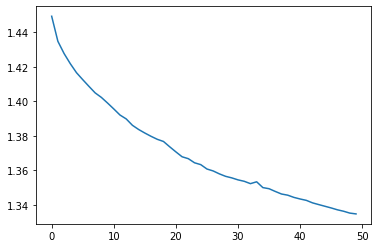

Epoch 1/50
8/8 - 3s - loss: 1.6608 - accuracy: 0.1926 - auc_6: 0.4315 - precision_6: 0.1429 - recall_6: 0.0123 - f1_score: 0.0855 - val_loss: 2.0699 - val_accuracy: 0.1230 - val_auc_6: 0.3717 - val_precision_6: 0.1429 - val_recall_6: 0.0082 - val_f1_score: 0.0568 - 3s/epoch - 339ms/step
Epoch 2/50
8/8 - 1s - loss: 1.6127 - accuracy: 0.1926 - auc_6: 0.4355 - precision_6: 0.1000 - recall_6: 0.0082 - f1_score: 0.0870 - val_loss: 1.9846 - val_accuracy: 0.1230 - val_auc_6: 0.3735 - val_precision_6: 0.1429 - val_recall_6: 0.0082 - val_f1_score: 0.0564 - 651ms/epoch - 81ms/step
Epoch 3/50
8/8 - 1s - loss: 1.5675 - accuracy: 0.1926 - auc_6: 0.4385 - precision_6: 0.1111 - recall_6: 0.0082 - f1_score: 0.0874 - val_loss: 1.9030 - val_accuracy: 0.1230 - val_auc_6: 0.3761 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0560 - 654ms/epoch - 82ms/step
Epoch 4/50
8/8 - 1s - loss: 1.5276 - accuracy: 0.1926 - auc_6: 0.4380 - precision_6: 0.2000 - recall_6: 0.0082 - f1_score: 0

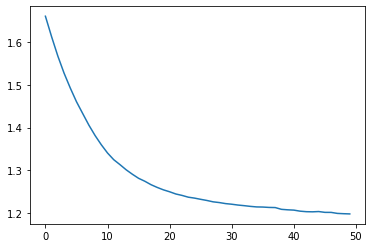

Epoch 1/50
8/8 - 3s - loss: 1.8441 - accuracy: 0.1516 - auc_7: 0.4925 - precision_7: 0.1429 - recall_7: 0.0574 - f1_score: 0.1070 - val_loss: 1.5206 - val_accuracy: 0.2131 - val_auc_7: 0.5084 - val_precision_7: 0.1463 - val_recall_7: 0.0492 - val_f1_score: 0.1311 - 3s/epoch - 347ms/step
Epoch 2/50
8/8 - 1s - loss: 1.8112 - accuracy: 0.1516 - auc_7: 0.4922 - precision_7: 0.1837 - recall_7: 0.0369 - f1_score: 0.1061 - val_loss: 1.4884 - val_accuracy: 0.2049 - val_auc_7: 0.5090 - val_precision_7: 0.1739 - val_recall_7: 0.0328 - val_f1_score: 0.1258 - 665ms/epoch - 83ms/step
Epoch 3/50
8/8 - 1s - loss: 1.7858 - accuracy: 0.1475 - auc_7: 0.4946 - precision_7: 0.2143 - recall_7: 0.0246 - f1_score: 0.1079 - val_loss: 1.4599 - val_accuracy: 0.2049 - val_auc_7: 0.5089 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.1325 - 706ms/epoch - 88ms/step
Epoch 4/50
8/8 - 1s - loss: 1.7597 - accuracy: 0.1434 - auc_7: 0.4954 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - f1_

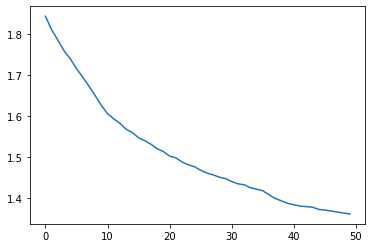

In [14]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    baseline_face_model = Baseline(n_features, n_length, n_outputs)
    history = baseline_face_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [15]:
y_pred = baseline_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = baseline_face_model.evaluate(X_test, y_test)
results.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 31.60% 
Balanced Accuracy: 24.39% 
ROC/AUC: 0.62 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.19


## 3. Multimodal Early Fusion

### Dataset

In [16]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(nopain=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3])
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[-1], y_train.shape[1]

(366, 350, 60) (366, 4)
(231, 350, 60) (231, 4)


In [17]:
model = Baseline(n_features, n_length, n_outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 350, 60)]         0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                22200     
                                                                 
 dense_16 (Dense)            (None, 50)                2550      
                                                                 
 dense_17 (Dense)            (None, 4)                 204       
                                                                 
Total params: 24,954
Trainable params: 24,954
Non-trainable params: 0
_________________________________________________________________


### Baseline Model

Epoch 1/50
8/8 - 3s - loss: 1.5584 - accuracy: 0.1516 - auc_9: 0.3970 - precision_9: 0.5000 - recall_9: 0.0164 - f1_score: 0.0665 - val_loss: 1.6387 - val_accuracy: 0.1639 - val_auc_9: 0.3869 - val_precision_9: 0.7500 - val_recall_9: 0.0246 - val_f1_score: 0.0709 - 3s/epoch - 339ms/step
Epoch 2/50
8/8 - 1s - loss: 1.5360 - accuracy: 0.1598 - auc_9: 0.4057 - precision_9: 0.6667 - recall_9: 0.0164 - f1_score: 0.0728 - val_loss: 1.6135 - val_accuracy: 0.1639 - val_auc_9: 0.3951 - val_precision_9: 0.7500 - val_recall_9: 0.0246 - val_f1_score: 0.0709 - 651ms/epoch - 81ms/step
Epoch 3/50
8/8 - 1s - loss: 1.5208 - accuracy: 0.1598 - auc_9: 0.4145 - precision_9: 0.6667 - recall_9: 0.0164 - f1_score: 0.0725 - val_loss: 1.5978 - val_accuracy: 0.1639 - val_auc_9: 0.4002 - val_precision_9: 0.7500 - val_recall_9: 0.0246 - val_f1_score: 0.0704 - 652ms/epoch - 81ms/step
Epoch 4/50
8/8 - 1s - loss: 1.5063 - accuracy: 0.1516 - auc_9: 0.4241 - precision_9: 0.6667 - recall_9: 0.0164 - f1_score: 0.0658 - 

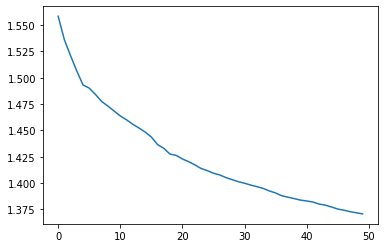

Epoch 1/50
8/8 - 3s - loss: 1.5073 - accuracy: 0.4467 - auc_10: 0.7435 - precision_10: 0.3855 - recall_10: 0.1311 - f1_score: 0.2065 - val_loss: 1.1981 - val_accuracy: 0.5246 - val_auc_10: 0.7323 - val_precision_10: 0.5000 - val_recall_10: 0.1475 - val_f1_score: 0.4168 - 3s/epoch - 392ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4561 - accuracy: 0.4672 - auc_10: 0.7482 - precision_10: 0.4110 - recall_10: 0.1230 - f1_score: 0.2257 - val_loss: 1.2046 - val_accuracy: 0.5164 - val_auc_10: 0.7256 - val_precision_10: 0.4865 - val_recall_10: 0.1475 - val_f1_score: 0.4135 - 653ms/epoch - 82ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4385 - accuracy: 0.4631 - auc_10: 0.7493 - precision_10: 0.3944 - recall_10: 0.1148 - f1_score: 0.2243 - val_loss: 1.1892 - val_accuracy: 0.5164 - val_auc_10: 0.7346 - val_precision_10: 0.5556 - val_recall_10: 0.1230 - val_f1_score: 0.4135 - 652ms/epoch - 81ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4354 - accuracy: 0.4590 - auc_10: 0.7571 - precision_10: 0.3846 - recall_10: 0.0820 

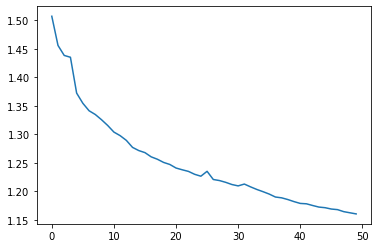

Epoch 1/50
8/8 - 3s - loss: 1.5212 - accuracy: 0.2418 - auc_11: 0.4725 - precision_11: 0.1765 - recall_11: 0.0123 - f1_score: 0.1560 - val_loss: 1.5163 - val_accuracy: 0.2213 - val_auc_11: 0.4307 - val_precision_11: 0.1429 - val_recall_11: 0.0082 - val_f1_score: 0.1433 - 3s/epoch - 351ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4973 - accuracy: 0.2377 - auc_11: 0.5043 - precision_11: 0.1538 - recall_11: 0.0082 - f1_score: 0.1541 - val_loss: 1.4917 - val_accuracy: 0.2295 - val_auc_11: 0.4413 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_f1_score: 0.1481 - 668ms/epoch - 84ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4590 - accuracy: 0.2418 - auc_11: 0.5227 - precision_11: 0.1429 - recall_11: 0.0082 - f1_score: 0.1637 - val_loss: 1.4787 - val_accuracy: 0.2377 - val_auc_11: 0.4533 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_f1_score: 0.1634 - 662ms/epoch - 83ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4380 - accuracy: 0.2500 - auc_11: 0.5377 - precision_11: 0.0833 - re

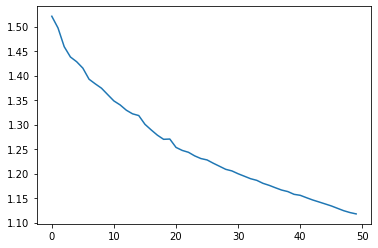

In [18]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = Baseline(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [19]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
results.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 24.68% 
Balanced Accuracy: 26.42% 
ROC/AUC: 0.58 
Precision: 0.29 
Recall: 0.02 
F1 score: 0.20


## 4. Multimodal Late Fusion

### Dataset

In [20]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True, nopain=False)
body_X_train = body_X_train.reshape(body_X_train.shape[0], body_X_train.shape[2], body_X_train.shape[3])
body_X_test = body_X_test.reshape(body_X_test.shape[0], body_X_test.shape[2], body_X_test.shape[3])
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(366, 350, 35) (366, 4)
(231, 350, 35) (231, 4)


In [21]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', nopain=False)
face_X_train = face_X_train.reshape(face_X_train.shape[0], face_X_train.shape[2], face_X_train.shape[3])
face_X_test = face_X_test.reshape(face_X_test.shape[0], face_X_test.shape[2], face_X_test.shape[3])
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(366, 350, 25) (366, 4)
(231, 350, 25) (231, 4)


In [22]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[1], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### Baseline Model

In [23]:
class fusioned_Baseline():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(n_length, body_features))
        lstm_1 = LSTM(50)(input_1)
        dense_1 = Dense(50)(lstm_1)

        input_2 = Input(shape=(n_length, face_features))
        lstm_2 = LSTM(50)(input_2)
        dense_2 = Dense(50)(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

    def summary(self):
        self.model.summary()

In [24]:
model = fusioned_Baseline(body_features, face_features, n_length, n_outputs)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 350, 35)]    0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 350, 25)]    0           []                               
                                                                                                  
 lstm_12 (LSTM)                 (None, 50)           17200       ['input_13[0][0]']               
                                                                                                  
 lstm_13 (LSTM)                 (None, 50)           15200       ['input_14[0][0]']               
                                                                                           

### Baseline Model

Epoch 1/50
8/8 - 4s - loss: 1.5559 - accuracy: 0.6434 - auc_13: 0.8075 - precision_13: 0.7324 - recall_13: 0.2131 - f1_score: 0.1962 - val_loss: 1.0982 - val_accuracy: 0.6066 - val_auc_13: 0.8089 - val_precision_13: 0.6111 - val_recall_13: 0.0902 - val_f1_score: 0.2067 - 4s/epoch - 537ms/step
Epoch 2/50
8/8 - 1s - loss: 1.5110 - accuracy: 0.6270 - auc_13: 0.8189 - precision_13: 0.7500 - recall_13: 0.1107 - f1_score: 0.2036 - val_loss: 1.1231 - val_accuracy: 0.6148 - val_auc_13: 0.8059 - val_precision_13: 0.6154 - val_recall_13: 0.0656 - val_f1_score: 0.2620 - 821ms/epoch - 103ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4916 - accuracy: 0.6230 - auc_13: 0.8238 - precision_13: 0.8095 - recall_13: 0.0697 - f1_score: 0.2294 - val_loss: 1.1351 - val_accuracy: 0.6475 - val_auc_13: 0.8078 - val_precision_13: 1.0000 - val_recall_13: 0.0082 - val_f1_score: 0.2994 - 810ms/epoch - 101ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4576 - accuracy: 0.6270 - auc_13: 0.8218 - precision_13: 0.7857 - recall_13: 0.045

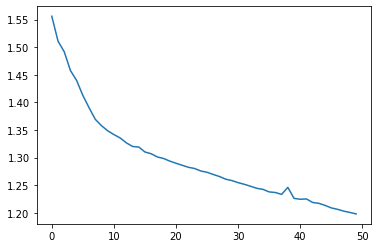

Epoch 1/50
8/8 - 5s - loss: 1.4223 - accuracy: 0.1639 - auc_14: 0.3399 - precision_14: 0.0667 - recall_14: 0.0041 - f1_score: 0.1015 - val_loss: 1.8316 - val_accuracy: 0.0984 - val_auc_14: 0.3030 - val_precision_14: 0.5000 - val_recall_14: 0.0164 - val_f1_score: 0.0742 - 5s/epoch - 627ms/step
Epoch 2/50
8/8 - 1s - loss: 1.3495 - accuracy: 0.1844 - auc_14: 0.3494 - precision_14: 0.1111 - recall_14: 0.0041 - f1_score: 0.1100 - val_loss: 1.7080 - val_accuracy: 0.1148 - val_auc_14: 0.3115 - val_precision_14: 0.0000e+00 - val_recall_14: 0.0000e+00 - val_f1_score: 0.0962 - 890ms/epoch - 111ms/step
Epoch 3/50
8/8 - 1s - loss: 1.3052 - accuracy: 0.1885 - auc_14: 0.3601 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00 - f1_score: 0.1249 - val_loss: 1.6112 - val_accuracy: 0.1311 - val_auc_14: 0.3391 - val_precision_14: 0.0000e+00 - val_recall_14: 0.0000e+00 - val_f1_score: 0.1117 - 881ms/epoch - 110ms/step
Epoch 4/50
8/8 - 1s - loss: 1.2639 - accuracy: 0.2090 - auc_14: 0.3852 - precision_14: 0

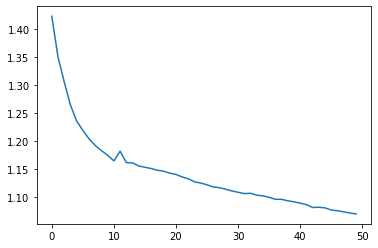

Epoch 1/50
8/8 - 5s - loss: 1.6620 - accuracy: 0.0164 - auc_15: 0.1751 - precision_15: 0.0187 - recall_15: 0.0082 - f1_score: 0.0208 - val_loss: 2.0859 - val_accuracy: 0.0000e+00 - val_auc_15: 0.1873 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.0000e+00 - 5s/epoch - 621ms/step
Epoch 2/50
8/8 - 1s - loss: 1.5919 - accuracy: 0.0328 - auc_15: 0.1832 - precision_15: 0.0263 - recall_15: 0.0041 - f1_score: 0.0512 - val_loss: 1.9759 - val_accuracy: 0.0000e+00 - val_auc_15: 0.1880 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.0000e+00 - 839ms/epoch - 105ms/step
Epoch 3/50
8/8 - 1s - loss: 1.5405 - accuracy: 0.0369 - auc_15: 0.1922 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00 - f1_score: 0.0556 - val_loss: 1.9050 - val_accuracy: 0.0000e+00 - val_auc_15: 0.1869 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.0000e+00 - 840ms/epoch - 105ms/step
Epoch 4/50
8/8 - 1s - loss: 1.5133 - accuracy: 0.0369 - 

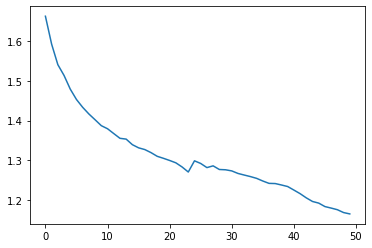

In [25]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_Baseline(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=d_class_weights)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [26]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
results.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 25.54% 
Balanced Accuracy: 25.26% 
ROC/AUC: 0.60 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.20


### Ensemble

In [27]:
baseline_body_member = KerasMember(name="Body Model", keras_model=baseline_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
baseline_face_member = KerasMember(name="Face Model", keras_model=baseline_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [28]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(baseline_body_member)
dirichletEnsemble.add_member(baseline_face_member)
dirichletEnsemble.fit()

In [29]:
e = dirichletEnsemble.describe()
results.append(round(e, 2))

Body Model (weight: 0.9973)
Face Model (weight: 0.0027)
Accuracy: 41.13% - ROC/AUC: 0.49 - Precision: 0.31 - Recall: 0.29 - F1 score: 0.29


## Results

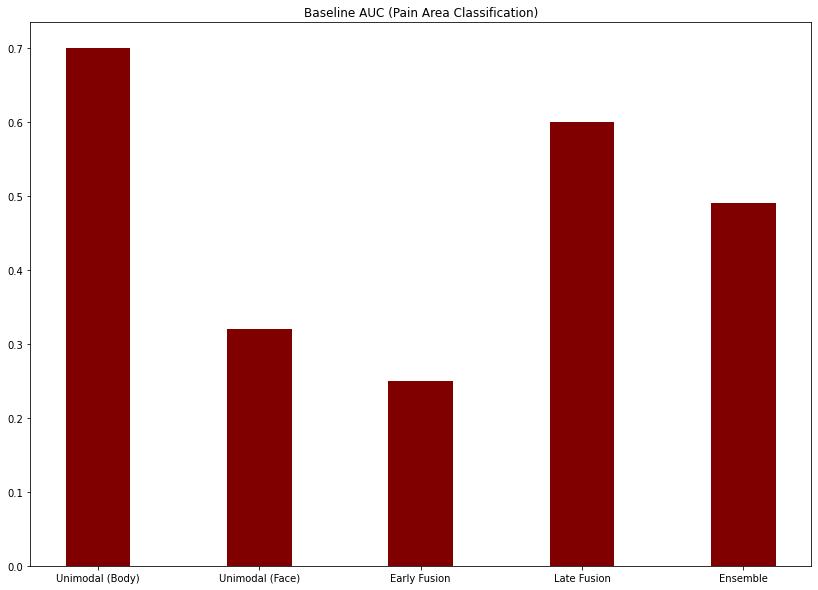

In [30]:
data = {'Unimodal (Body)':results[0], 'Unimodal (Face)':results[1], 'Early Fusion':results[2],
        'Late Fusion':results[3], 'Ensemble':results[4]}
models = list(data.keys())
performance = list(data.values())
  
fig = plt.figure(figsize = (14, 10))
 
plt.bar(models, performance, color ='maroon',
        width = 0.4)
 
plt.title("Baseline AUC (Pain Area Classification)")
plt.show()